In [61]:
#puts above directory into the path
import sys
sys.path.append("../../VREP_robot")
sys.path.append("../../VREP_robot/utils")
sys.path.append("../")
import vrep
from vrepRobot import *

from forwardKinematics import robot_config
import numpy as np
import time

pi = np.pi

In [62]:
# myRobot = robot_config()
# vrep_env = VREP_Environement()
# robot_handles  = ['pose_j0', 'pose_j1', 'pose_j2', 'pose_j3', 'pose_j4', 'pose_j5', 'pose_j6', 'pose_j7']
# vrep_env.add_robot(VREP_Robot('robot', robot_handles))
# vrep_env.start_simulation()

# Setup Environment

In [63]:
# setup environment
myRobot = robot_config()
# vrep_env = VREP_Environement(synchronous=False)
vrep_env = VREP_Environement(synchronous=True)
ik_handles = ['ik_joint1', 'ik_joint2', 'ik_joint3', 'ik_joint4', 'ik_joint5', 'ik_joint6', 'ik_joint7', 'ik_ee', 'kinematicsTest_IKTip', 'ik_rf7_static']
vrep_env.add_robot(VREP_Robot('ik_robot', ik_handles, connection_type = 'nonblocking'))
vrep_env.start_simulation()

Connected to remote API server
In synchronous mode
1 robot(s) connected: ['ik_robot']


In [64]:
# start = time.time()

# while time.time() - start < 18:
#     dt = time.time() - start
#     a = np.sin(dt)*0.5
#     q = np.array([0.2, -2.5, 0., 0., 0., 0., 0. + a])
#     positions = np.zeros((8,3))
#     positions[1:,:] = (myRobot.forwardKinPos(q))
#     orientations = np.zeros((8, 4)) #4 for quat
#     orientations[0,-1] = 1

#     print('Forward kinematic positions: {}'.format(positions))
#     orientations[1:,:] = myRobot.forwardKinOrientation(q)
#     print('Forward kinematic orientations: {}'.format(orientations))

#     print(vrep_env.robot.handle_names)
#     for i in range(len(robot_handles)):
#         vrep_env.robot.setObjectPosition(vrep_env.robot.handles[i], positions[i])
#         vrep_env.robot.setObjectQuaternion(vrep_env.robot.handles[i], orientations[i])
        
#     time.sleep(0.2)

In [65]:
#JEE = myRobot.J('EE', q)
#print("analytic jacobian: \n{}".format(JEE))

In [66]:
vrep_env.ik_robot.getCollisionHandle('Collision')
time.sleep(1)

# Initialization

In [67]:
# initialize collision check
# !!!important
vrep_env.ik_robot.getCollisionState(initialize=True)
vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static',initialize=True)
vrep_env.ik_robot.getObjectOrientation(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static',initialize=True)
vrep_env.ik_robot.getObjectQuaternion(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static',initialize=True)
time.sleep(0.5)
vrep_env.ik_robot.getCollisionState(initialize=True)
vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static',initialize=True)
vrep_env.ik_robot.getObjectOrientation(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static',initialize=True)
vrep_env.ik_robot.getObjectQuaternion(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static',initialize=True)

(0,
 [-0.8101062774658203,
  0.1923750638961792,
  0.3916119933128357,
  0.3916116952896118])

# Generate Configs
### set sample number here

In [68]:
# generate config samples
from configGenerator_VREP import configGenerator_VREP
config = configGenerator_VREP.generate_sample(5)  # !!!set sample number here
total_config = config.shape[0]
print("total configs = ", total_config)
print(config)
print(total_config/50/3600)

joint lower limit
 [-0.1        -0.045      -1.57079633 -0.90757121 -0.87615528 -0.90757121
  0.        ]
joint upper limit
 [0.1        0.905      1.57079633 0.90757121 0.90408055 0.90757121
 0.055     ]
total configs =  15625
[[-0.1        -0.045      -1.57079633 -0.90757121 -0.87615528 -0.90757121]
 [-0.1        -0.045      -1.57079633 -0.90757121 -0.87615528 -0.45378561]
 [-0.1        -0.045      -1.57079633 -0.90757121 -0.87615528  0.        ]
 ...
 [ 0.1         0.905       1.57079633  0.90757121  0.90408055  0.        ]
 [ 0.1         0.905       1.57079633  0.90757121  0.90408055  0.45378561]
 [ 0.1         0.905       1.57079633  0.90757121  0.90408055  0.90757121]]
0.08680555555555555


# Collision Detect

In [69]:
# initialize collision state placeholder
y = np.zeros((total_config))
EEPosition = np.zeros((total_config,3))
EEOrientation = np.zeros((total_config,3))
EEQuaternion = np.zeros((total_config,4))

In [70]:
# collision detect
from tqdm import tqdm_notebook as tqdm

pbar = tqdm(total=total_config)  # set progress bar

t = time.clock()
for i in range(total_config):
#for i in range(len(jointAngle)):
    joint_angle = config[i, :]
    for j in range(6):
        vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[j], joint_angle[j])
    #vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[5], jointAngle[i])
    
    vrep.simxSynchronousTrigger(vrep_env.clientID)
    #vrep.simxGetPingTime(vrep_env.clientID)
    #time.sleep(1)
    collisionState = vrep_env.ik_robot.getCollisionState()
    #print(collisionState)
    y[i] = collisionState
    vrep.simxSynchronousTrigger(vrep_env.clientID)
    #vrep.simxGetPingTime(vrep_env.clientID)
    EEPosition[i,:] = vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    EEOrientation[i,:] = vrep_env.ik_robot.getObjectOrientation(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    EEQuaternion[i,:] = vrep_env.ik_robot.getObjectQuaternion(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    pbar.update(1)
#     time.sleep(0.5)
    #print(EEPosition[i,:])
    
    #if i%int(total_config/100+1) == 0:
    #    Data = np.hstack((config, y.reshape(-1,1),EEPosition,EEOrientation,EEQuaternion))
    #    #np.save(r'C:\Users\xumw1\Documents\GitHub\robotPathPlanning\logs\CollisionData{}.npy'.format(i),Data)
    #    np.save('logs/CollisionData{}.npy'.format(i),Data)
    
pbar.close()
print('runtime = ', time.clock()-t)  
print('collision state = ', y)
print('EEPosition\n', EEPosition)
print('EEPrientation\n', EEOrientation)
print('EEQuaternion\n', EEQuaternion)
#np.save(r'C:\Users\xumw1\Documents\GitHub\robotPathPlanning\logs\CollisionData.npy',Data)
Data = np.hstack((config, y.reshape(-1,1),EEPosition,EEOrientation,EEQuaternion))
np.save('logs/CollisionData.npy',Data)


runtime =  383.8233633462087
collision state =  [1. 1. 1. ... 1. 1. 1.]
EEPosition
 [[-0.10452056  0.34297428 -0.38671896]
 [-0.14968014  0.33849886 -0.3198767 ]
 [-0.17160153  0.30635628 -0.24906999]
 ...
 [-0.18119943  0.0674648   0.73147911]
 [-0.17531407  0.11334148  0.66523701]
 [-0.14231181  0.13536909  0.59486002]]
EEPrientation
 [[-2.01463223 -0.49269596 -2.32834673]
 [-1.55867672 -0.76222014 -2.05514359]
 [-0.90757006 -0.87615514 -1.57079589]
 ...
 [-0.90757191 -0.90408105  1.57079637]
 [-1.57537854 -0.78429163  1.06254101]
 [-2.0282886  -0.50501668  0.78470683]]
EEQuaternion
 [[-0.20463535 -0.80454409 -0.39422914  0.39422908]
 [-0.11070836 -0.69524145 -0.43015796  0.56510812]
 [-0.01110656 -0.55030072 -0.44403714  0.70701969]
 ...
 [-0.55644733  0.00123414  0.7071057   0.43631008]
 [-0.70124978  0.09935093  0.56380934  0.42484975]
 [-0.81010628  0.19237506  0.39161199  0.3916117 ]]


# Save Data

In [71]:
Data = np.hstack((config, y.reshape(-1,1),EEPosition,EEOrientation,EEQuaternion))
np.save('logs/CollisionData.npy',Data)

# Plot

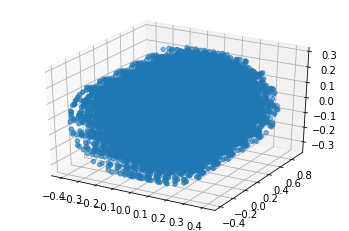

In [72]:
# plot
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-EEPosition[:,1], EEPosition[:,2], -EEPosition[:,0])
plt.show()

In [14]:
EEPosition_free = EEPosition[y==0,:]
print(EEPosition_free)

[[ 4.76837158e-07  4.99997139e-02 -2.98023224e-07]
 [ 4.76837158e-07  4.99997139e-02 -2.98023224e-07]
 [ 4.76837158e-07  4.99997139e-02 -2.98023224e-07]
 [-1.04520559e-01  3.42974275e-01 -3.86718959e-01]
 [ 1.60609722e-01  3.35150450e-01 -3.92831564e-01]
 [ 2.29224920e-01  2.97039360e-01 -2.56349087e-01]
 [ 1.90337062e-01  1.80906147e-01 -1.57410860e-01]
 [-1.04520798e-01  2.51007736e-01 -1.90651685e-01]
 [ 3.04125547e-02  2.51007736e-01 -1.32385552e-01]
 [ 3.16315889e-02  1.19994521e-01 -4.50811982e-02]
 [ 3.09406519e-02 -2.94686854e-02 -9.45610702e-02]
 [ 1.60609603e-01  2.51007676e-01 -2.00580090e-01]
 [ 2.29225039e-01  1.19994581e-01 -1.46585196e-01]
 [ 1.90337300e-01 -2.94686258e-02 -1.77186906e-01]
 [-1.71601415e-01 -8.48174393e-02 -2.11241782e-01]
 [ 3.04125547e-02 -6.03005290e-03 -1.06538922e-01]
 [ 3.16318274e-02 -1.55486554e-01 -1.56028986e-01]
 [ 3.09410095e-02 -2.08514541e-01 -3.04270416e-01]
 [ 1.60609663e-01  4.77080941e-02 -1.48523748e-01]
 [ 1.90337300e-01 -1.43404514e-

 [-1.04520440e-01  1.42974287e-01  8.82810354e-02]]


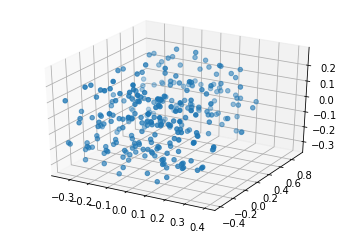

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-EEPosition_free[:,1], EEPosition_free[:,2], -EEPosition_free[:,0])
plt.show()

In [16]:
#test
# EEPosition = np.zeros((5,3))
# joint_angle = np.linspace(0,1,5)
# for i in range(5):
#     vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[0], joint_angle[i])
#     vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[1], joint_angle[i])
#     vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[3], joint_angle[i])
#     vrep.simxSynchronousTrigger(vrep_env.clientID)
#     vrep.simxGetPingTime(vrep_env.clientID)
#     collisionState = vrep_env.ik_robot.getCollisionState()
#     EEPosition[i,:] = vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
#     time.sleep(1)
#     print(collisionState)
# print('EEPosition\n', EEPosition)

In [17]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(-EEPosition[:,1], EEPosition[:,2], -EEPosition[:,0])
# plt.show()

## orientation dictionary work

In [51]:
import transforms3d as t3d
import numpy as np

def quantizeOrientationsBins(numBins, quaternions):
    #numBins is per axis --> numBins**2
    #using spherical coordinates: https://en.wikipedia.org/wiki/Spherical_coordinate_system
    #theta 0 is - pi/2 to pi/2
    #phi is -pi to pi
    #orientations is in quaternions
    
    quaternions = np.roll(quaternions, 1).copy()#we need w, x, y, z; vrep uses x, y, z, w
    
    thetaInterval = np.linspace(-np.pi/2, np.pi/2, num=numBins+1)
    phiInterval = np.linspace(-np.pi, np.pi, num=numBins+1)
    
    spherical = np.zeros((quaternions.shape[0],2)) #phi, theta
    for i in range(spherical.shape[0]):
        # mod
        if quaternions.ndim != 1:
            rotMat = t3d.quaternions.quat2mat(quaternions[i,:])
        else:
            rotMat = t3d.quaternions.quat2mat(quaternions)
        cartesian = rotMat@np.ones((3,1))
        spherical[i,0] = np.arctan2(cartesian[1], cartesian[0]) # phi
        spherical[i,1] = np.arctan2(np.sqrt(cartesian[0]**2 + cartesian[1]**2), cartesian[2]) - np.pi/2 # theta
        
    binCounts = np.zeros((numBins,numBins))
    for i in range(numBins):
        for j in range(numBins):
            temp = np.stack((np.logical_and(spherical[:,1] > thetaInterval[i], spherical[:,1] < thetaInterval[i+1]),
                             np.logical_and(spherical[:,0] > phiInterval[j], spherical[:,0] < phiInterval[j+1])), axis = 1)
            #print(temp.shape)
            temp = temp.all(axis=1)
            binCounts[i,j] = np.sum(temp)
    return binCounts, spherical, temp, thetaInterval, phiInterval

binCounts, spherical, temp, thetaInterval, phiInterval = quantizeOrientationsBins(4, EEQuaternion)

print(binCounts)

[[ 18.  26.  45.  45.]
 [ 63.  81.  92. 107.]
 [  0.  72.  72.  81.]
 [  0.   9.   9.   9.]]


In [21]:
start = time.time()
for i in range(1000):
    binCounts, spherical, temp, thetaInterval, phiInterval = quantizeOrientationsBins(4, EEQuaternion) 
end = time.time()
end - start



20.62088894844055